# Construcción del Grafo Poblacional de Costa Rica a nivel Distrital
Este cuaderno carga datos geoespaciales y poblacionales para construir un grafo de distritos contiguos con sus respectivas poblaciones como peso nodal.

In [ ]:
!pip install geopandas shapely networkx pandas matplotlib openpyxl scikit-learn

In [ ]:
# Librerías
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [8]:
# Cargar shapefile de distritos (UGED 2022)
# Tomado de: https://inec.cr/mapas-cartografia/unidad-geoestadistica-distrital-2022

shapefile_path = "data/UGED_MGN_2022/UGED_MGN_2022.shp"
gdf_distritos = gpd.read_file(shapefile_path)
gdf_distritos = gdf_distritos[gdf_distritos.geometry.notnull()].copy()
gdf_distritos.set_crs(epsg=5367, inplace=True)  # CRS oficial de Costa Rica
gdf_distritos[["NOMB_UGED", "COD_UGED", "AREA_KM2"]].head(15)

print(gdf_distritos.shape)

(492, 7)


In [ ]:
# gdf_distritos

# Mostrar la tabla resultante
with pd.option_context("display.max_rows", None):
    display(gdf_distritos)

In [ ]:
# # Guardar el DataFrame como archivo Excel
# df_distritos.to_excel("df_distritos.xlsx")

In [6]:
# Recargar con el excel nuevo:
df_distritos = pd.read_excel("data/df_distritos.xlsx")  # distritos poblacion de 2022

# # Eliminar columnas cuyo nombre comience con 'Unnamed'
df_distritos = df_distritos.loc[:, ~df_distritos.columns.str.startswith("Unnamed")]

df_distritos
# Mostrar la tabla resultante
# with pd.option_context('display.max_rows', None):
#     display(df_distritos)

,Codigo,Distrito,Total
0,10101,CARMEN,2946
1,10102,MERCED,15408
2,10103,HOSPITAL,24030
3,10104,CATEDRAL,15682
4,10105,ZAPOTE,21990
...,...,...,...
487,70601,GUACIMO,26152
488,70602,MERCEDES,2357
489,70603,POCORA,8494
490,70604,RIO JIMENEZ,11836


In [7]:
# # Datos estadísticos de los distritos
df_distritos["Total"].describe()

count      492.000000
mean     10659.150407
std      11346.219640
min         20.000000
25%       3114.250000
50%       6938.500000
75%      13221.500000
max      89531.000000
Name: Total, dtype: float64

In [ ]:
# # Contar cuántos distritos tienen nombres repetidos
repetidos = df_distritos["Distrito"].value_counts()
nombres_repetidos = repetidos[repetidos > 1].index.tolist()

# nombres_repetidos

In [ ]:
# Extraer tabla con todos los distritos con nombre repetido
df_repetidos = df_distritos[df_distritos["Distrito"].isin(nombres_repetidos)].copy()

# Mostrar la cantidad de nombres repetidos
print(f"Nombres de distrito repetidos: {len(nombres_repetidos)}")

# Mostrar la tabla resultante
with pd.option_context("display.max_rows", None):
    display(df_repetidos)

In [ ]:
media = df_distritos["Total"].mean()
desviacion = df_distritos["Total"].std()
mediana = df_distritos["Total"].median()
minimo = df_distritos["Total"].min()
maximo = df_distritos["Total"].max()

print(f"Media: {media:,.0f}")
print(f"Desviación estándar: {desviacion:,.0f}")
print(f"Mediana: {mediana:,.0f}")
print(f"Mínimo: {minimo:,.0f}")
print(f"Máximo: {maximo:,.0f}")

In [ ]:
# Localizar distrito con el valor máximo
distrito_max = df_distritos[df_distritos["Total"] == df_distritos["Total"].max()]
distrito_min = df_distritos[df_distritos["Total"] == df_distritos["Total"].min()]
print(distrito_max)
print(distrito_min)

In [ ]:
# Convertir a string y rellenar con ceros a la izquierda (5 dígitos)
df_distritos["Codigo"] = df_distritos["Codigo"].astype(str).str.zfill(5)

# Verificar primeros resultados
df_distritos

In [9]:
# # Normalizar nombres para asegurar coincidencias
gdf_distritos["COD_UGED_clean"] = gdf_distritos["COD_UGED"].str.strip().str.upper()
df_distritos["Codigo_clean"] = df_distritos["Codigo"].str.strip().str.upper()


# Unir por nombres limpios
gdf = gdf_distritos.merge(
    df_distritos, left_on="COD_UGED_clean", right_on="Codigo_clean", how="left"
)
# gdf = df_poblacion.merge(gdf_distritos, left_on="Nombre_clean", right_on="NOMB_UGED_clean", how="left")
gdf = gdf.dropna(subset=["Total"])
gdf = gdf.set_index("COD_UGED")


# # with pd.option_context('display.max_rows', None):
# #     display(gdf)


# # # Asegurarse de que COD_UGED esté como columna temporalmente
# gdf = gdf.reset_index("COD_UGED")

# # Comparar con la fila anterior para encontrar duplicados contiguos en ambas columnas
# duplicados_D = (gdf["Distrito"] == gdf["Distrito"].shift())
# duplicados_I = (gdf["ID"] == gdf["ID"].shift())
# duplicados_C = (gdf["COD_UGED"] == gdf["COD_UGED"].shift())
# duplicados_N = (gdf["NOMB_UGED"] == gdf["NOMB_UGED"].shift())
# duplicados_NU = (gdf["NOMB_UGEC"] == gdf["NOMB_UGEC"].shift())
# duplicados_NP = (gdf["NOMB_UGEP"] == gdf["NOMB_UGEP"].shift())
# duplicados_NC = (gdf["NOMB_UGED_clean"] == gdf["NOMB_UGED_clean"].shift())
# Total = (gdf["Total"] < gdf["Total"].shift())

# # Identificar las filas que deben eliminarse: son duplicadas y tienen menor Total que la anterior
# condicion_eliminar = (duplicados_D & duplicados_I & duplicados_C & duplicados_N & duplicados_NU & duplicados_NP & duplicados_NC &Total)

# # Eliminar esas filas
# gdf = gdf[~condicion_eliminar].copy()

# # Restaurar el índice original
# gdf = gdf.set_index("COD_UGED")


gdf

AttributeError: Can only use .str accessor with string values!

In [ ]:
# # # Asegurarse de que COD_UGED esté como columna temporalmente
# gdf = gdf.reset_index()

# # Asegúrate de que la columna 'Est. 2022' sea numérica
# gdf["Total"] = pd.to_numeric(gdf["Total"], errors="coerce")

# # Ordenar por población descendente para que la mayor quede primero
# gdf = gdf.sort_values("Total", ascending=False)

# # Eliminar duplicados conservando la de mayor población
# gdf = gdf.drop_duplicates(subset="COD_UGED", keep="first")

# # Restaurar el índice si es necesario
# gdf = gdf.set_index("COD_UGED")


# gdf

In [ ]:
# Crear grafo de contigüidad
G = nx.Graph()

# Agregar nodos con población
for idx, row in gdf.iterrows():
    G.add_node(idx, nombre=row["NOMB_UGED"], poblacion=row["Total"])

# Agregar aristas entre distritos contiguos
for i, geom in gdf.geometry.items():
    vecinos = gdf[gdf.geometry.touches(geom)].index
    for v in vecinos:
        if not G.has_edge(i, v):
            G.add_edge(i, v)

## Visualización del Grafo y Métricas

NameError: name 'gdf' is not defined

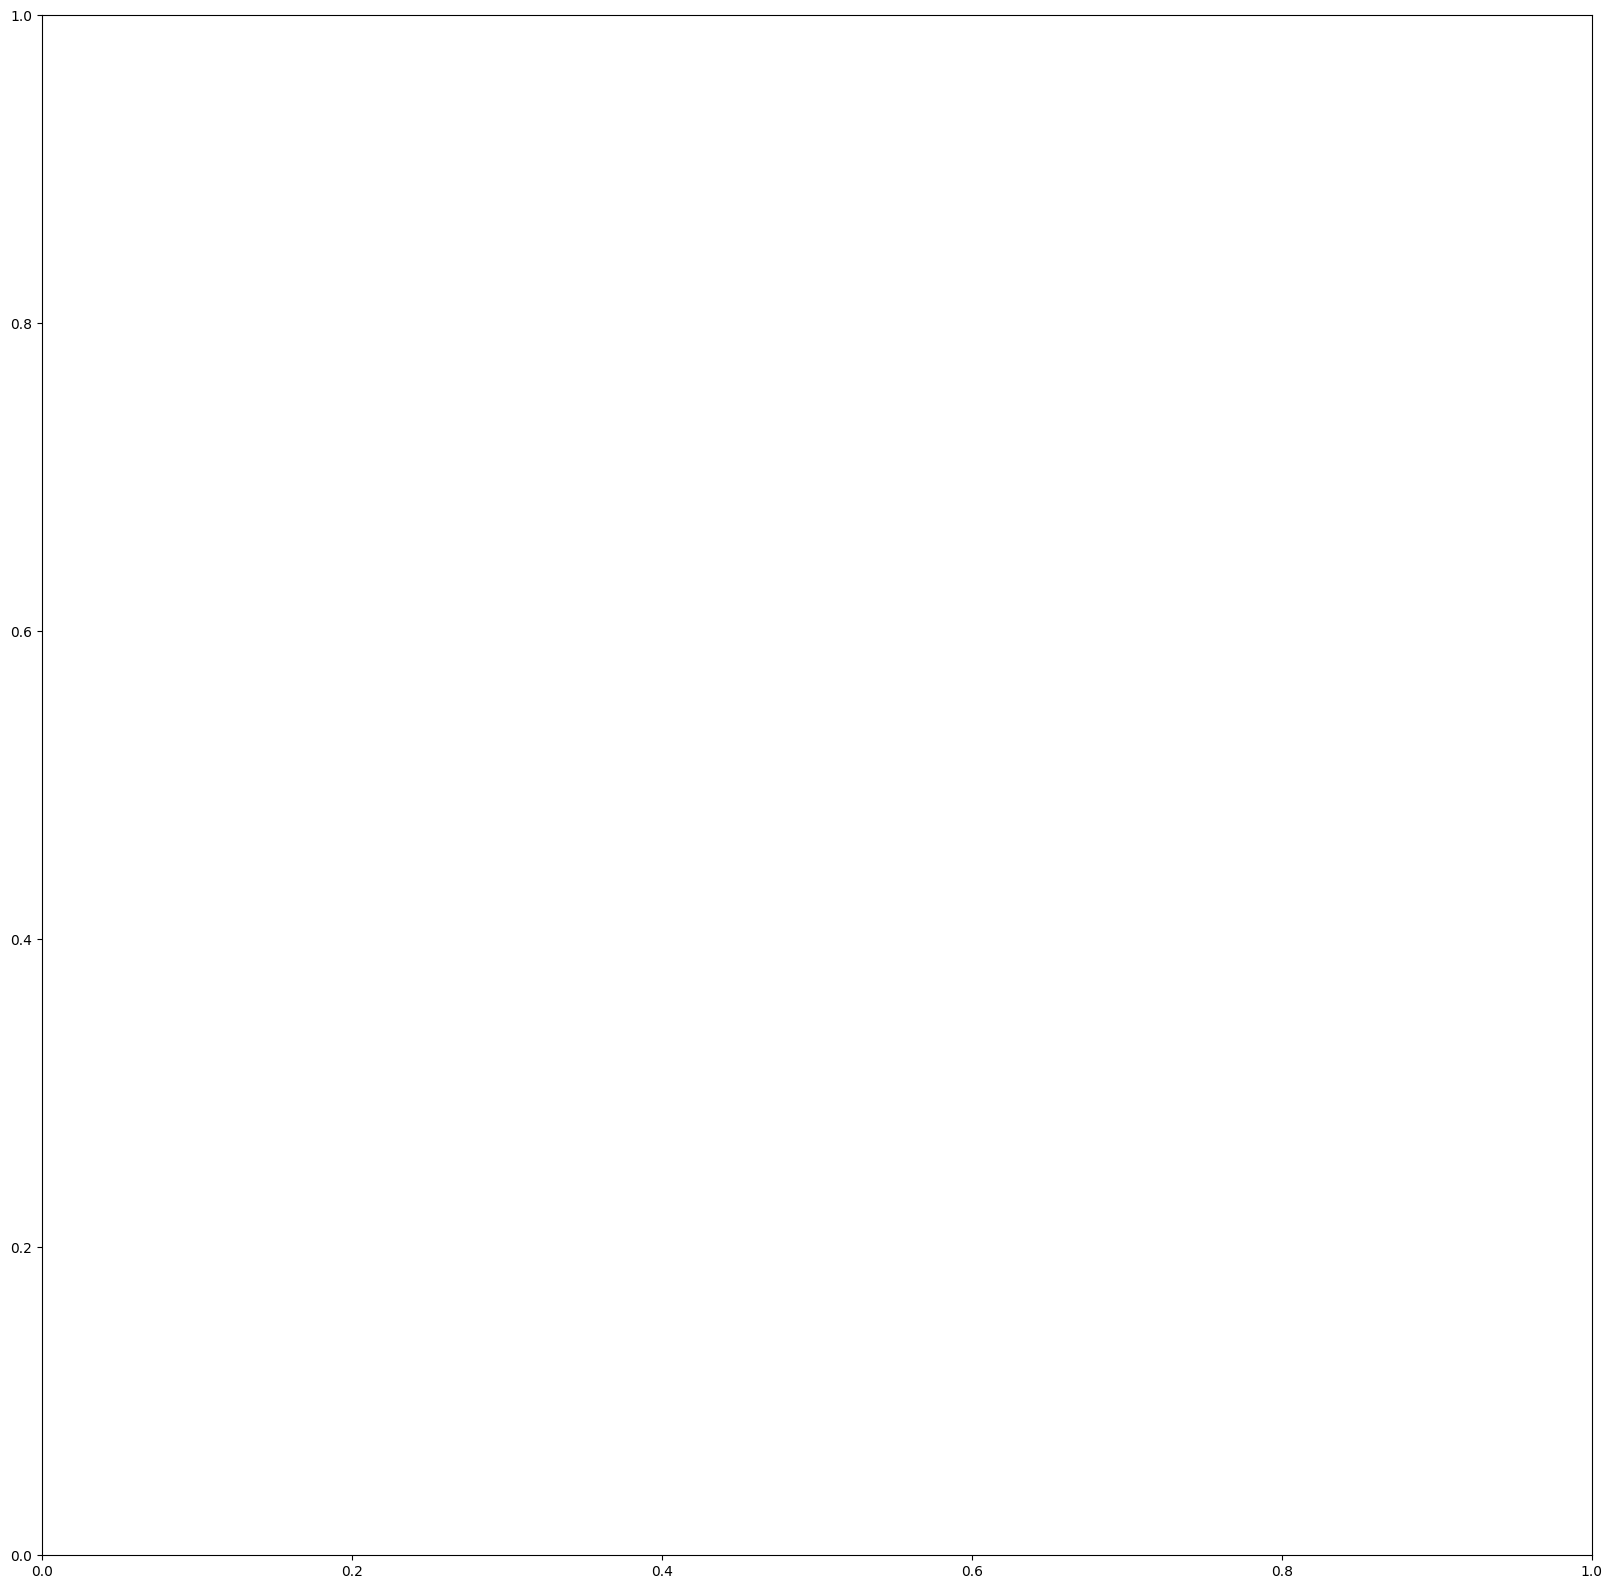

In [10]:
# Visualización del grafo sobre el mapa
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax, color="lightgreen", edgecolor="black")
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=6, ha="center")
plt.title("Distritos y sus etiquetas (COD_UGED)")
plt.axis("off")
plt.show()

In [ ]:
# (Opcional) Calcular densidad si tenemos área
# gdf["densidad"] = gdf["Total"] / gdf.geometry.area

# Si solo queremos población para color:
columna_color = "Total"  # O "densidad" si la calculas

# Crear visualización con colormap
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax, column=columna_color, cmap="coolwarm", edgecolor="black", legend=True)

# Añadir etiquetas por distrito (opcional)
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=5, ha="center")

plt.title(f"Distritos coloreados por {columna_color}")
plt.axis("off")
plt.show()

In [ ]:
# Definir rango deseado para los colores
vmin = 20
vmax = 10659

# Visualización con escala personalizada
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(
    ax=ax,
    column=columna_color,
    cmap="coolwarm",
    edgecolor="black",
    legend=True,
    vmin=vmin,
    vmax=vmax,
)

# Añadir etiquetas por distrito
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=5, ha="center")

plt.title(f"Distritos coloreados por {columna_color} (Escala: {vmin}-{vmax})")
plt.axis("off")
plt.show()

In [ ]:
# Asegurar que estamos en la proyección correcta
gdf = gdf.to_crs(epsg=5367)

# Recorte espacial: Bounding Box aproximada para el Valle Central
gdf_valle = gdf.cx[470000:510000, 1090000:1125000]

# Visualizar solo los distritos del Valle Central con escala fija
fig, ax = plt.subplots(figsize=(10, 10))
gdf_valle.plot(
    ax=ax,
    column="Total",
    cmap="coolwarm",
    edgecolor="black",
    legend=True,
    vmin=0,
    vmax=10000,
)

# Añadir etiquetas opcionales
for i, row in gdf_valle.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row["Distrito"]), fontsize=4, ha="center")

plt.title("Distritos del Valle Central de Costa Rica (Zoom, Total 0–10000)")
plt.axis("off")
plt.show()

In [ ]:
# Visualizar el grafo de contigüidad (sin base geográfica)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=10, with_labels=False)
plt.title("Grafo de contigüidad entre distritos")
plt.show()

In [ ]:
# Métricas del grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
grados = [d for _, d in G.degree()]
print(f"Grado medio: {sum(grados) / len(grados):.2f}")
print(f"Número de componentes conexas: {nx.number_connected_components(G)}")

## Métricas de Evaluación de Distritos

### 1. Desviación estándar de la población
Esto permite evaluar qué tan equitativos son los distritos en términos de carga poblacional.

In [ ]:
# import numpy as np

poblaciones = [data["poblacion"] for _, data in G.nodes(data=True)]
media_pob = np.mean(poblaciones)
desviacion = np.std(poblaciones)
print(f"Promedio de población por distrito: {media_pob:.2f}")
print(f"Desviación estándar poblacional: {desviacion:.2f}")

### 2. Verificación de contigüidad
Cada distrito debe formar parte de un grafo conexo. Aquí verificamos si el grafo total tiene más de una componente conexa.

In [ ]:
componentes = list(nx.connected_components(G))
print(f"Número de componentes conexas: {len(componentes)}")
if len(componentes) == 1:
    print("Todos los distritos están contiguamente conectados.")
else:
    print("Advertencia: hay distritos desconectados.")

### 3. Índice de Polsby-Popper (Compacidad)
Este índice mide cuán compacto es un distrito según su forma geométrica. El valor ideal es cercano a 1 (circular).

$$
\text{Polsby-Popper} = \frac{4\pi \cdot A}{P^2}
$$

donde:

- $A$ es el área del distrito,
- $P$ es el perímetro del distrito.

Este índice toma valores en el intervalo $(0,1]$, siendo **1** la forma más compacta (un círculo perfecto).


In [ ]:
def polsby_popper(geom):
    if geom and geom.area > 0 and geom.length > 0:
        return (4 * np.pi * geom.area) / (geom.length**2)
    return 0


gdf["polsby_popper"] = gdf.geometry.apply(polsby_popper)
gdf[["NOMB_UGED", "polsby_popper"]].sort_values(
    by="polsby_popper", ascending=True
).head(100)

gdf

##  ¿Cuántos distritos $k$ proponer?

In [ ]:
# Procedemos a analizar con detalle para el problema de distritacion politica (PDP)

# Calcula el coeficiente de variación poblacional
cv = gdf["Total"].std() / gdf["Total"].mean()
print(cv)

In [ ]:
# Añade la columna Polsby_Popper:
gdf["area"] = gdf.geometry.area
gdf["perimeter"] = gdf.geometry.length
gdf["polsby_popper"] = (4 * np.pi * gdf["area"]) / (gdf["perimeter"] ** 2)

gdf

In [ ]:
# Verifica contigüidad
G = nx.Graph()
for i, geom_i in gdf.geometry.items():
    G.add_node(i)
    for j, geom_j in gdf.geometry.items():
        if i != j and geom_i.touches(geom_j):
            G.add_edge(i, j)

componentes = list(nx.connected_components(G))
distritos_multiples = [c for c in componentes if len(c) < 2]

In [ ]:
# k optimo
pob_total = gdf["Total"].sum()
pob_por_distrito = 89474  # promedio nacional por diputado
k = int(round(pob_total / pob_por_distrito))
print(k)

## Módulo de Redistribución Electoral tipo 'Caso Alemán' para Costa Rica

In [ ]:
# Paso 1: Estimar número óptimo de distritos uninominales
poblacion_total = gdf["Total"].sum()
meta_poblacional = 89474  # objetivo basado en diputados actuales
k = round(poblacion_total / meta_poblacional)
print(f"Número estimado de distritos (k): {k}")

In [ ]:
# Calcular centroides y extraer coordenadas
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf["centroid"].x
gdf["y"] = gdf["centroid"].y

In [ ]:
coords = gdf[["x", "y"]].values

In [ ]:
# Nuevo valor de k
poblacion_total = gdf["Total"].sum()
meta_poblacional = 45000  # nueva cantidad
cantidad_diputados = poblacion_total / meta_poblacional


k = round(poblacion_total / meta_poblacional)
print(f"Número estimado de distritos (k): {k}")

In [ ]:
# Paso 2: Aplicar K-means usando coordenadas geográficas
# from sklearn.cluster import KMeans

coords = gdf[["x", "y"]].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(coords)
gdf["DistritoNuevo"] = kmeans.labels_

gdf.plot(
    column="DistritoNuevo",
    categorical=True,
    figsize=(20, 20),
    legend=False,
    edgecolor="k",
)

In [ ]:
# Asegurar que estamos en la proyección correcta
gdf = gdf.to_crs(epsg=5367)

# Recorte espacial: Bounding Box aproximada para el Valle Central
gdf_valle = gdf.cx[470000:510000, 1090000:1125000]

# Visualizar solo los distritos del Valle Central con escala fija
fig, ax = plt.subplots(figsize=(10, 10))
gdf_valle.plot(
    ax=ax,
    column="Total",
    cmap="tab20",
    edgecolor="black",
    legend=True,
    vmin=0,
    vmax=10000,
)

# Añadir etiquetas opcionales
for i, row in gdf_valle.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row["DistritoNuevo"]), fontsize=4, ha="center")

plt.title(
    "Distritos del Valle Central de Costa Rica (Zoom, Total 0–10000), version Kmeans"
)
plt.axis("off")
plt.show()

In [ ]:
# Paso 3: Evaluar población por nuevo distrito
agrupado = (
    gdf.groupby("DistritoNuevo")["Total"]
    .agg(["count", "sum"])
    .rename(columns={"count": "NumDistritos", "sum": "Poblacion"})
)
agrupado["Desviacion_%"] = (
    100 * (agrupado["Poblacion"] - meta_poblacional) / meta_poblacional
)
agrupado.sort_values(by="Poblacion")

In [ ]:
# Paso 4: Visualización de desviación poblacional

agrupado["Desviacion_%"].plot(
    kind="bar", figsize=(12, 5), title="Desviación porcentual poblacional por distrito"
)
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("% desviación")
plt.grid(True)
plt.tight_layout()
plt.show()

## Clustering con DBSCAN ponderado por densidad poblacional

In [ ]:
# Paso 1: Asegurarse de tener coordenadas x, y de centroides
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf["centroid"].x
gdf["y"] = gdf["centroid"].y
coords = gdf[["x", "y"]].values

In [ ]:
# Paso 2: Normalizar coordenadas
# from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

In [ ]:
# Paso 3: Aplicar DBSCAN considerando densidad poblacional como pesos
# from sklearn.cluster import DBSCAN

# DBSCAN requiere definir eps (radio) y min_samples (núcleo mínimo)
dbscan = DBSCAN(eps=0.5, min_samples=5)
gdf["DBSCAN_cluster"] = dbscan.fit_predict(coords_scaled)

gdf.plot(
    column="DBSCAN_cluster",
    categorical=True,
    figsize=(20, 20),
    legend=True,
    edgecolor="k",
)

In [ ]:
# Paso 4: Evaluar agrupaciones por población total
agrupado_dbscan = (
    gdf.groupby("DBSCAN_cluster")["Total"]
    .agg(["count", "sum"])
    .rename(columns={"count": "NumDistritos", "sum": "Poblacion"})
)
agrupado_dbscan = agrupado_dbscan.sort_values(by="Poblacion", ascending=False)
agrupado_dbscan

## Partición de Grafo por Clustering Espectral (Spectral Clustering)

In [ ]:
# Paso 1: Crear matriz de adyacencia ponderada por proximidad y población
# from sklearn.preprocessing import normalize
# from sklearn.cluster import SpectralClustering
# import numpy as np
# import networkx as nx

gdf = gdf.reset_index(drop=True)


G = nx.Graph()
G.add_nodes_from(gdf.index)
for i, geom_i in gdf.geometry.items():
    for j, geom_j in gdf.geometry.items():
        if i < j and geom_i.touches(geom_j):
            pop_diff = abs(gdf.loc[i, "Total"] - gdf.loc[j, "Total"]) + 1
            weight = 1 / pop_diff
            G.add_edge(i, j, weight=weight)

A = nx.to_numpy_array(G, nodelist=gdf.index, weight="weight")

In [ ]:
# Paso 2: Aplicar Clustering Espectral
spectral = SpectralClustering(
    n_clusters=k, affinity="precomputed", assign_labels="kmeans", random_state=42
)
gdf["Distrito_Spectral"] = spectral.fit_predict(A)

In [ ]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(
    column="Distrito_Spectral", cmap="tab20", linewidth=0.2, edgecolor="black", ax=ax
)
plt.title("Partición Espectral del Grafo de Distritos")
plt.axis("off")
plt.show()

In [ ]:
# Asegurar que estamos en la proyección correcta
gdf = gdf.to_crs(epsg=5367)

# Recorte espacial: Bounding Box aproximada para el Valle Central
gdf_valle = gdf.cx[470000:510000, 1090000:1125000]

# Visualizar solo los distritos del Valle Central con escala fija
fig, ax = plt.subplots(figsize=(10, 10))
gdf_valle.plot(
    ax=ax,
    column="Total",
    cmap="tab20",
    edgecolor="black",
    legend=True,
    vmin=0,
    vmax=10000,
)

# Añadir etiquetas opcionales
for i, row in gdf_valle.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, str(row["Distrito_Spectral"]), fontsize=4, ha="center"
    )

plt.title(
    "Distritos del Valle Central de Costa Rica (Zoom, Total 0–10000), version Spectral"
)
plt.axis("off")
plt.show()

## Distritación por Provincias


In [ ]:
gdf

In [ ]:
# Filtrar filas donde NOMB_UGEP sea 'SAN JOSE'
gdf_san_jose = gdf[gdf["NOMB_UGEP"] == "SAN JOSE"].copy()
# # Restaurar el índice si es necesario
gdf_san_jose = gdf_san_jose.set_index("Codigo")

gdf_san_jose

In [ ]:
# Crear grafo de contigüidad
G_san_jose = nx.Graph()

# Agregar nodos con población
for idx, row in gdf_san_jose.iterrows():
    G_san_jose.add_node(idx, nombre=row["NOMB_UGED"], poblacion=row["Total"])

# Agregar aristas entre distritos contiguos
for i, geom in gdf_san_jose.geometry.items():
    vecinos = gdf_san_jose[gdf_san_jose.geometry.touches(geom)].index
    for v in vecinos:
        if not G_san_jose.has_edge(i, v):
            G_san_jose.add_edge(i, v)

In [ ]:
# Visualización del grafo sobre el mapa
fig, ax = plt.subplots(figsize=(15, 15))
gdf_san_jose.plot(ax=ax, color="lightgreen", edgecolor="black")
for i, row in gdf_san_jose.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=6, ha="center")
plt.title("Distritos de San Jose y sus etiquetas (COD_UGED)")
plt.axis("off")
plt.show()

In [ ]:
# Visualizar el grafo de contigüidad (sin base geográfica)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_san_jose, seed=42)
nx.draw(G_san_jose, pos, node_size=10, with_labels=True)
plt.title("Grafo de contigüidad entre distritos")
plt.show()

In [ ]:
# Métricas del grafo
print(f"Número de nodos: {G_san_jose.number_of_nodes()}")
print(f"Número de aristas: {G_san_jose.number_of_edges()}")
grados = [d for _, d in G_san_jose.degree()]
print(f"Grado medio: {sum(grados) / len(grados):.2f}")
print(f"Número de componentes conexas: {nx.number_connected_components(G_san_jose)}")

In [ ]:
# Paso 1: Estimar número óptimo de distritos uninominales
poblacion_total_sj = gdf_san_jose["Total"].sum()
print(poblacion_total_sj)

meta_poblacional = 30000  # objetivo basado en diputados actuales

curules_sj = poblacion_total_sj / meta_poblacional

print(curules_sj)

k_sj = round(poblacion_total / meta_poblacional)
print(f"Número estimado de distritos (k): {k_sj}")

In [ ]:
# Calcular centroides y extraer coordenadas
gdf_san_jose["centroid"] = gdf_san_jose.geometry.centroid
gdf_san_jose["x"] = gdf_san_jose["centroid"].x
gdf_san_jose["y"] = gdf_san_jose["centroid"].y

In [ ]:
# Paso 2: Aplicar K-means usando coordenadas geográficas
# from sklearn.cluster import KMeans

coords = gdf_san_jose[["x", "y"]].values
kmeans = KMeans(n_clusters=k_sj, random_state=0, n_init=10).fit(coords)
gdf_san_jose["DistritoNuevo"] = kmeans.labels_

gdf_san_jose.plot(
    column="DistritoNuevo",
    categorical=True,
    figsize=(10, 10),
    legend=False,
    edgecolor="k",
)

In [ ]:
# Paso 3: Evaluar población por nuevo distrito
agrupado = (
    gdf_san_jose.groupby("DistritoNuevo")["Total"]
    .agg(["count", "sum"])
    .rename(columns={"count": "NumDistritos", "sum": "Poblacion"})
)
agrupado["Desviacion_%"] = (
    100 * (agrupado["Poblacion"] - meta_poblacional) / meta_poblacional
)
agrupado.sort_values(by="Poblacion")

In [ ]:
# Paso 4: Visualización de desviación poblacional

agrupado["Desviacion_%"].plot(
    kind="bar", figsize=(12, 5), title="Desviación porcentual poblacional por distrito"
)
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("% desviación")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Paso 1: Crear matriz de adyacencia ponderada por proximidad y población
# from sklearn.preprocessing import normalize
# from sklearn.cluster import SpectralClustering
# import numpy as np
# import networkx as nx

gdf_san_jose = gdf_san_jose.reset_index(drop=True)


G_san_jose = nx.Graph()
G_san_jose.add_nodes_from(gdf_san_jose.index)
for i, geom_i in gdf_san_jose.geometry.items():
    for j, geom_j in gdf_san_jose.geometry.items():
        if i < j and geom_i.touches(geom_j):
            pop_diff = (
                abs(gdf_san_jose.loc[i, "Total"] - gdf_san_jose.loc[j, "Total"]) + 1
            )
            weight = 1 / pop_diff
            G.add_edge(i, j, weight=weight)

A = nx.to_numpy_array(G_san_jose, nodelist=gdf_san_jose.index, weight="weight")

In [ ]:
# Paso 2: Aplicar Clustering Espectral
spectral = SpectralClustering(
    n_clusters=k_sj, affinity="precomputed", assign_labels="kmeans", random_state=42
)
gdf_san_jose["Distrito_Spectral"] = spectral.fit_predict(A)

In [ ]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf_san_jose.plot(
    column="Distrito_Spectral", cmap="tab20", linewidth=0.2, edgecolor="black", ax=ax
)
plt.title("Partición Espectral del Grafo de Distritos")
plt.axis("off")
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
from IPython.display import display

# Paso 1: Sumar población total por nuevo distrito
poblacion_distritos = gdf_san_jose.groupby("Distrito_Spectral")["Total"].sum()

# Paso 2: Calcular población ideal (promedio)
poblacion_total = poblacion_distritos.sum()
num_distritos = poblacion_distritos.size
poblacion_ideal = poblacion_total / num_distritos

# Paso 3: Calcular desviación absoluta y relativa
desviaciones = pd.DataFrame(
    {
        "Poblacion": poblacion_distritos,
        "Desviacion_Absoluta": poblacion_distritos - poblacion_ideal,
        "Desviacion_Relativa_%": 100
        * (poblacion_distritos - poblacion_ideal)
        / poblacion_ideal,
    }
)

# Paso 4: Métricas agregadas
desviacion_max = desviaciones["Desviacion_Relativa_%"].abs().max()
std_dev = desviaciones["Desviacion_Relativa_%"].std()
cv = std_dev / 100  # Coeficiente de variación (en proporción)

# Mostrar tabla
display(desviaciones)

# Mostrar métricas agregadas
print(f"Población total: {poblacion_total}")
print(f"Población ideal por distrito: {poblacion_ideal:.2f}")
print(f"Desviación máxima relativa: {desviacion_max:.2f}%")
print(f"Desviación estándar relativa: {std_dev:.2f}%")
print(f"Coeficiente de variación: {cv:.4f}")